# Econ 1923 - Product Differentiation Project

## 1 Preparation
### 1.1 Obtaining the data
Create a data set containing nutrition information about cereal boxes. You can use all sources including the nutrition APIs, stores web pages, actual grocery stores, your pantry, etc.
At the end of this process, you should have a dataframe that contains as many cereal boxes as possible and for each, you should have several nutritional facts and (ideally) serving sizes (cups or grams).
The result of this part can be several dataframes, each resulting from the different data sources that you used.

Sources: Edemam API, GitHub JSON Files, personal cereals


In [45]:
#Importing packages
import requests, json, time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%run ../APIkeys.py

In [4]:
app_id = os.environ['EDAMAM_API_id']
key = os.environ['EDAMAM_API_key']
#baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
#endURL = '&nutrition-type=cooking&category=packaged-foods'

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [5]:
def checkUPC_edamam(upc):
    # This function is called checkUPC_V2 in previous notebooks
    
    edamam_id = os.environ['EDAMAM_API_id']
    edamam_key = os.environ['EDAMAM_API_key']
    edamam_baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+edamam_id+'&app_key='+edamam_key+'&upc='
    edamam_endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = edamam_baseURL + upc + edamam_endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [20]:
#We add a 2 second interval between each call to stay under the limit for the Edamam API.

def multiUPC_edamam(shelf, verbose = False, leftovers = False, source=""):
    # This function is called multiUPC_V2 in previous notebooks
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_edamam(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
                time.sleep(2)
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
                time.sleep(2)
            found.append(info)
    
    # turn the dictionary found into a Dataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found,unfound
    else:
        return df_found

Get Whole Foods Cereals 

In [56]:
url = "https://raw.githubusercontent.com/ArieBeresteanu/Econ-1923/main/Cereal_Project/cereal_WholeFoods.json"
response = json.loads(requests.get(url).text)

# skipping the first entry
df_WF = pd.DataFrame(response['cereal'])

# Getting the shape of the dataframe:
# n = number of rows (observations)
# c = number of columns
n,c = df_WF.shape

# names of columns
df_WF.columns

Index(['label', 'ENERC_KCAL', 'FAT', 'FASAT', 'FATRN', 'CHOLE', 'NA', 'Carb',
       'Fiber', 'SUGAR', 'SUGAR.added', 'Protein', 'VITD', 'P', 'Iron',
       'Calcium', 'servingSize_cup', 'servingSize_Gram', 'FAPOLY', 'FAMONO',
       'FOLAC', 'VitB6A', 'NIA', 'MG'],
      dtype='object')

In [72]:
# rename columns
df_WF = df_WF.rename(columns={"ENERC_KCAL": "CALORIES", 
                              "Carb": "CARB", 
                              "Protein": "PROTEIN", 
                              "Iron": "IRON", 
                              "Calcium": "CALCIUM", 
                              "Fiber": "FIBER",
                              'VitB6A': 'VITB6A',
                              "FAMONO": "FATMONO"
                             })
df_WF['dataSource'] = 'GiantEagle / WholeFoods'
df_WF

label  CALORIES   FAT  FASAT  \
0   Purely Elizabeth, Original Ancient Grain Grano...       130   6.0    3.5   
1        Catalina Crunch, Cinnamon Toast Cereal, 9 oz       110   5.0    0.5   
2        Catalina Crunch, Dark Chocolate Cereal, 9 oz       110   6.0    1.0   
3         Michele's Granola,  Original Granola, 12 oz       150   9.0    2.0   
4   365 by Whole Foods Market, Organic Cereal, Oat...       240   7.0    0.5   
5   Nature's Path Organic, Heritage Flakes Cereal,...       160   1.5    0.0   
6                        Cheerios Honey Nut , 15.4 oz       180   2.0    0.0   
7   Nature's Path Organic, Heritage Flakes Cereal,...       160   1.5    0.0   
8   Cascadian Farm, Organic Cinnamon Crunch Cereal...       180   3.0    0.0   
9   365 by Whole Foods Market, Granola Maple Almon...       260   9.0    1.0   
10  365 by Whole Foods Market, Raisin Bran Cereal,...       170   1.0    0.0   
11  Purely Elizabeth. Blueberry Hemp Ancient Grain...       130   5.0    NaN   
12  KIND Snacks, Peanut Butter Whole Grain Cluster...       120   4.0    0.5   
13  KIND Snacks, Kind Healthy Grains Oats & Honey ...       110   2.5    5.0   
14          Main Street, Chunky Granola With Flaxseed       250  11.0    1.0   
15    Bob's Red Mill, Old Country Style Muesli, 40 oz       140   3.0    0.0   
16  365 by Whole Foods Market, Organic Morning O's...       150   2.5    0.0   
17  Nature's Path Organic, Organic Heritage Flakes...       200   1.5    0.0   
18  365 by Whole Foods Market, Organic Cereal Hone...       150   1.5    0.0   
19  365 by Whole Foods Market, Organic Cereal, Fre...       270   8.0    1.0   
20       Kashi. Go Lean Peanut Butter Crunch, 13.2 oz       220   9.0    1.0   
21  Nature's Path Organic, Mesa Sunrise Cereal, Fa...       160   1.5    1.0   
22  Nature's Path Organic. Dark Chocolate & Red Be...       130   5.0    1.0   
23   Nature's Path Organic, Panda Puffs Cereal, 10 oz       170   4.5    1.5   
24         Michele's Granola, Cinnamon Raisin , 12 oz       140   8.0    2.0   
25  Catalina Crunch, Keto Friendly Fruity Cereal, ...       110   5.0    0.5   
26  Annie's Homegrown, Organic Cocoa Bunnies Oat, ...       140   2.0    0.5   
27  Kashi, Heart To Heart Organic Blueberry Cluste...       200   2.5    0.5   
28  Barbara's Bakery, Peanut Butter Puffins Cereal...       160   2.5    0.5   
29  Purely Elizabeth, Coconut Cashew Grain-Free Gr...       170  13.0    5.0   
30  Nature's Path Organic, Flax Plus Raisin Bran C...       210   2.5    0.0   
31  365 by Whole Foods Market. Organic Cereal, Glu...       140   3.0    0.0   
32             Post. The Original Grape Nuts, 20.5 oz       200   1.0    0.0   
33      Cascadian Farm, Organic Honey Almond, 14.4 oz       210   2.5    0.0   
34      Paleonola, Grain Free Original Granola, 10 oz       170  15.0    3.5   
35          Bob's Red Mill, Gluten Free Muesli, 16 oz       120   3.5    1.0   
36    Kashi, Chocolate Crunch Go Lean Cereal, 12.2 oz       210   7.0    1.5   
37  Nature's Path Organic, Dark Chocolate & Peanut...       150   5.0    0.5   
38  365 by Whole Foods Market, Organic Peanut Butt...       150   2.0    0.0   
39  One Degree Organic Foods, Brown Rice Cacao Cri...       140   1.5    0.0   
40  Nature's Path Organic, Honey Almond Granola, 1...       140   4.5    0.5   
41  Nature's Path Organic, Choco Chimps Cereal, 10 oz       150   1.0    0.5   
42  365 by Whole Foods Market, Cereal, Protein & F...       220   6.0    0.5   
43     Kashi, Organic Honey Toasted Oat Cereal, 12 oz       150   2.5    0.0   
44  Jessica's Natural Foods. Chocolate Chip Granol...       260  12.0    3.5   
45             General Mills, Rice Chex Cereal, 12 oz       160   1.0    0.0   
46  Food for Life, Ezekiel 4:9 Almond Sprouted Gra...       200   3.0    0.0   
47  Forager Project, Organic Grain-free Gluten-fre...       110   1.5    0.0   
48  KIND Snacks, Almond Butter Whole Grains Cluste...       110   2.5    0.0   
49  Nature's Path Organic, Sunrise Crunchy Vanil

In [23]:
#reading excel and csv files containing states' WIC 
#Approved Products Lists (APLs) and filtering down to cereal UPCs

df_IL = pd.read_excel('IL_WIC_APL.xlsx') #Illinois
df_IL = df_IL.drop([174], axis=0)
df_IL = df_IL.reset_index(drop=True)

df_MA = pd.read_excel('MA_WIC_APL.xlsx')
df_MA = df_MA[df_MA['Category Name']=='Breakfast Cereal'] #Massachusetts
df_MA = df_MA.reset_index(drop=True)

df_MN = pd.read_excel('MN_WIC_APL.xlsx')#Minnesota

df_NE = pd.read_excel('NE_WIC_APL.xlsx')#Nebraska

df_NV = pd.read_csv('NV_WIC_APL.csv')#Nevada

df_NY = pd.read_excel('NY_WIC_APL.xlsx')#New York S
df_NY = df_NY[df_NY['Category']=='Breakfast Cereal ']
df_NY = df_NY.reset_index(drop=True)

In [24]:
#Isolating UPCs into string arrays and combining
IL_UPCs = []
for i in range(0,len(df_IL['UPC/PLU Code'])-1):
    IL_UPCs.append(df_IL['UPC/PLU Code'][i][7:18])
    
MA_UPCs = []
for i in range(0,len(df_MA['UPC'])-1):
    MA_UPCs.append(str(df_MA['UPC'][i]))

MN_UPCs = []
for i in range(0,len(df_MN['UPC_PLU'])-1):
    MN_UPCs.append(str(df_MN['UPC_PLU'][i]))
    
NE_UPCs = []
for i in range(0,len(df_NE['UPC'])-1):
    NE_UPCs.append(str(df_NE['UPC'][i]))

NV_UPCs = []
for i in range(0,len(df_NV['UPC'])-1):
    if len(df_NV['UPC'][i])==14:
        NV_UPCs.append(df_NV['UPC'][i][2:13])
    elif len(df_NV['UPC'][i])==15:
        NV_UPCs.append(df_NV['UPC'][i][3:14])

NY_UPCs = []
for i in range(0,len(df_NY['UPC/PLU Number'])-1):
    if len(str(df_NY['UPC/PLU Number'][i]))==11:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i]))
    elif len(str(df_NY['UPC/PLU Number'][i]))==12:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i])[1:12])
        
UPCs = IL_UPCs + MA_UPCs + MN_UPCs + NE_UPCs + NV_UPCs + NY_UPCs #combining
UPCs = list(set(UPCs)) #removes duplicate UPCs, and then coerces into a list

In [25]:
found, unfound = multiUPC_edamam(UPCs, verbose = True, leftovers = True, source="Edamam_API")

UPC  38000202117  exists in the API's data base
UPC  688267070495  exists in the API's data base
UPC  41190033294  exists in the API's data base
UPC  41268202676  exists in the API's data base
UPC  16000170117  does not exist in the API's data base
UPC  11225124099  exists in the API's data base
UPC  41190065004  exists in the API's data base
UPC  16000264243  exists in the API's data base
UPC  41268208388  exists in the API's data base
UPC  84912320445  does not exist in the API's data base
UPC  70038606925  does not exist in the API's data base
UPC  42187541655  does not exist in the API's data base
UPC  688267155758  exists in the API's data base
UPC  18894110545  exists in the API's data base
UPC  16000487697  exists in the API's data base
UPC  36800110113  exists in the API's data base
UPC  884912249265  exists in the API's data base
UPC  884912006806  exists in the API's data base
UPC  11110810106  exists in the API's data base
UPC  11110878243  exists in the API's data base
UPC 

UPC  16000142442  does not exist in the API's data base
UPC  79166933064  does not exist in the API's data base
UPC  84912249265  does not exist in the API's data base
UPC  78742147048  exists in the API's data base
UPC  41735010179  exists in the API's data base
UPC  11161018377  exists in the API's data base
UPC  21130280193  exists in the API's data base
UPC  16000401051  exists in the API's data base
UPC  492310003206  exists in the API's data base
UPC  99771333041  does not exist in the API's data base
UPC  73296066104  does not exist in the API's data base
UPC  41303042311  exists in the API's data base
UPC  78742075648  exists in the API's data base
UPC  41735022103  does not exist in the API's data base
UPC  688267064517  exists in the API's data base
UPC  41268203642  does not exist in the API's data base
UPC  16000658509  exists in the API's data base
UPC  41303046319  exists in the API's data base
UPC  84912356178  does not exist in the API's data base
UPC  72400060182  exis

UPC  93476000145  does not exist in the API's data base
UPC  78742122083  exists in the API's data base
UPC  50700561240  exists in the API's data base
UPC  38000200663  exists in the API's data base
UPC  64144080304  exists in the API's data base
UPC  41303001790  exists in the API's data base
UPC  02185904601  does not exist in the API's data base
UPC  11110833037  exists in the API's data base
UPC  13130006965  exists in the API's data base
UPC  11110810113  exists in the API's data base
UPC  41735158420  does not exist in the API's data base
UPC  21333061087  exists in the API's data base
UPC  41268164219  exists in the API's data base
UPC  77890375761  exists in the API's data base
UPC  70253298424  exists in the API's data base
UPC  884912001870  exists in the API's data base
UPC  70253298790  exists in the API's data base
UPC  16000168756  does not exist in the API's data base
UPC  41190033287  exists in the API's data base
UPC  84912356291  does not exist in the API's data base

UPC  42400026815  exists in the API's data base
UPC  49705010044  exists in the API's data base
UPC  35826074997  exists in the API's data base
UPC  49705005460  exists in the API's data base
UPC  16000170032  does not exist in the API's data base
UPC  16000275492  exists in the API's data base
UPC  88267155758  does not exist in the API's data base
UPC  16000103719  exists in the API's data base
UPC  70784471648  does not exist in the API's data base
UPC  16000666603  exists in the API's data base
UPC  43000105405  exists in the API's data base
UPC  41268108336  exists in the API's data base
UPC  16000488366  exists in the API's data base
UPC  41190751228  exists in the API's data base
UPC  84912105107  does not exist in the API's data base
UPC  725439109895  exists in the API's data base
UPC  91669199104  does not exist in the API's data base
UPC  18894115410  does not exist in the API's data base
UPC  30000560839  exists in the API's data base
UPC  30000064429  exists in the API's d

UPC  41270813563  exists in the API's data base
UPC  16000625709  exists in the API's data base
UPC  75450127942  exists in the API's data base
UPC  35826100115  does not exist in the API's data base
UPC  884912249272  exists in the API's data base
UPC  42400084778  exists in the API's data base
UPC  38000199509  exists in the API's data base
UPC  38000596674  exists in the API's data base
UPC  41318290189  exists in the API's data base
UPC  50700561196  exists in the API's data base
UPC  24300031625  exists in the API's data base
UPC  70038342878  does not exist in the API's data base
UPC  688267064524  exists in the API's data base
UPC  42187408989  does not exist in the API's data base
UPC  41497530052  exists in the API's data base
UPC  38000200038  exists in the API's data base
UPC  84912014290  does not exist in the API's data base
UPC  49705005545  does not exist in the API's data base
UPC  98487952356  exists in the API's data base
UPC  50700561288  does not exist in the API's 

UPC  884912004710  exists in the API's data base
UPC  38000198823  does not exist in the API's data base
UPC  83921118999  does not exist in the API's data base
UPC  41190046775  exists in the API's data base
UPC  11153041901  exists in the API's data base
UPC  41497537310  exists in the API's data base
UPC  11225024603  exists in the API's data base
UPC  41735088604  does not exist in the API's data base
UPC  11225124044  exists in the API's data base
UPC  70038639985  exists in the API's data base
UPC  75130414072  exists in the API's data base
UPC  688267065316  exists in the API's data base
UPC  70038304821  exists in the API's data base
UPC  70784472652  exists in the API's data base
UPC  11153041857  does not exist in the API's data base
UPC  35882007010  does not exist in the API's data base
UPC  41303001783  exists in the API's data base
UPC  42400146322  exists in the API's data base
UPC  38000269967  does not exist in the API's data base
UPC  38000202124  does not exist in th

UPC  38000198410  exists in the API's data base
UPC  70253280290  exists in the API's data base
UPC  42400055075  does not exist in the API's data base
UPC  91669300388  does not exist in the API's data base
UPC  884912012784  exists in the API's data base
UPC  21859046209  exists in the API's data base
UPC  688267135750  exists in the API's data base
UPC  21130280490  exists in the API's data base
UPC  11110853110  exists in the API's data base
UPC  70784471983  exists in the API's data base
UPC  36800110175  exists in the API's data base
UPC  11110907585  does not exist in the API's data base
UPC  41270040914  exists in the API's data base
UPC  11110809414  exists in the API's data base
UPC  13733914000  does not exist in the API's data base
UPC  725439103091  exists in the API's data base
UPC  42187001500  does not exist in the API's data base
UPC  91669301224  does not exist in the API's data base
UPC  42400142997  exists in the API's data base
UPC  20794011760  does not exist in t

In [27]:
Found = pd.DataFrame(found)
Missing = pd.DataFrame(unfound)
print('There are ', len(Missing), ' missing UPCs.')
print('There are ', len(Found), ' found UPCs.')

There are  341  missing UPCs.
There are  690  found UPCs.


In [28]:
# Save raw data from Excel before making any changes
Found.to_excel("edamam_Raw.xlsx", sheet_name='Cereal Data')
Found

ENERC_KCAL        FAT     FASAT  FATRN      FAMS      FAPU     CHOCDF  \
0    339.000000   1.790000  0.000000    0.0  0.000000  0.000000  83.930000   
1    352.739619   0.000000  0.000000    0.0  0.000000  0.000000  84.657509   
2    357.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.709999   
3    345.000000   1.820000  0.000000    0.0  0.000000  0.910000  83.639999   
4    406.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.500000   
5    366.000000   6.100000  0.000000    0.0  2.440000  2.440000  73.169998   
6    357.142857   7.142857  0.000000    0.0       NaN       NaN  71.428571   
7    381.000000   4.760000  0.000000    0.0       NaN       NaN  78.570000   
8     67.628045   0.845351  0.000000    0.0  0.000000  0.281784  14.089176   
9    394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
10   379.310345   3.448276  0.000000    0.0       NaN       NaN  82.758621   
11   357.000000   0.000000  0.000000    0.0       NaN       NaN  85.709999   
12   405.000000   7.140000       NaN    0.0  3.570000  1.190000  80.949997   
13   400.000000   5.000000  0.000000    0.0  3.330000  0.000000  83.330002   
14   375.000000   3.120000  0.000000    0.0  0.000000  0.000000  78.120003   
15   345.000000   1.720000  0.000000    0.0  0.000000  0.860000  82.760002   
16   406.000000   7.810000  0.000000    0.0  4.690000  1.560000  81.250000   
17   370.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.190002   
18   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
19   380.405479   1.902027  0.000000    0.0       NaN       NaN  79.885151   
20   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
21   370.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.190002   
22   340.000000   2.130000  0.000000    0.0  0.000000  1.060000  82.980003   
23   394.000000   9.090000  1.520000    0.0  3.030000  3.030000  63.639999   
24   357.000000   5.360000  0.000000    0.0  1.790000  1.790000  75.000000   
25   367.000000   0.000000  0.000000    0.0       NaN       NaN  86.669998   
26   346.247495   1.731237  0.000000    0.0  0.000000  0.000000  77.905686   
27   357.142857   3.571429  0.000000    0.0       NaN       NaN  75.000000   
28   334.174376   1.670872  0.000000    0.0       NaN       NaN  80.201850   
29   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
30   393.000000   5.360000  0.000000    0.0  2.680000  1.790000  82.139999   
31   357.000000   7.140000  1.790000    0.0  1.790000  1.790000  67.860001   
32   350.000000   1.670000  0.000000    0.0  0.000000  0.830000  85.000000   
33   400.000000   3.330000  0.000000    0.0  0.000000  0.000000  76.669998   
34   357.142857   5.357143  0.000000    0.0  1.785714  1.785714  64.285714   
35   349.000000   1.590000  0.000000    0.0  0.000000  0.790000  82.540001   
36   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
37   386.000000   5.680000  0.000000    0.0  3.410000  1.140000  81.820000   
38   349.800123   2.057648  0.000000    0.0  0.000000  1.028824  78.190616   
39   348.384820   1.741924  0.000000    0.0       NaN       NaN  83.612357   
40   400.000000   3.333333  0.000000    0.0       NaN       NaN  83.333333   
41   345.000000   1.820000  0.000000    0.0  0.000000  0.910000  81.820000   
42   363.636364   3.030303  0.000000    0.0       NaN       NaN  84.848485   
43   350.000000   0.000000  0.000000    0.0       NaN       NaN  75.000000   
44   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
45   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
46   357.000000   7.140000  0.000000    0.0  1.790000  1.790000  67.860001   
47   379.000000   1.720000  0.000000    0.0  0.000000  0.000000  79.309998   
48   308.000000   2.560000  0.000000    0.0  0.000000  1.280000  79.489998   
49   407.610227   0.000000  0.000000    0.0       NaN       NaN  87.792972   
50   406.000000   7.810000 

In [29]:
#Missing

0
0     16000170117
1     84912320445
2     70038606925
3     42187541655
4     17544126904
5     88267169793
6     41270830775
7    884912359155
8     49705017883
9     16000183728
10    50700031897
11    42400178002
12    93476000282
13    51933342637
14    38000198809
15    21333060615
16    38000198656
17    41270019743
18    88267090998
19    84912003911
20    99771333102
21    42187425313
22    16000161672
23    11110876003
24   884912359162
25        3811009
26    30000571132
27    21130280865
28    41268155828
29    41270830799
30    16000178182
31    50700213712
32    35826074973
33    30000570241
34    49705105405
35    16000169623
36    70038604204
37    84912259363
38    50700200682
39    88267078729
40    93476000183
41    41497530441
42    88267090981
43    50700742960
44    13733913997
45    38000198458
46   884912356291
47    38000231537
48    73296034516
49    42187408750
50    16000142442
51    79166933064
52    84912249265
53    99771333041
54    73296066104
55    41735022103
56    41268203642
57    84912356178
58   622261091001
59    23627050142
60    38527135325
61    84912359155
62    49705017784
63    78742183961
64    70038618348
65    23627050081
66    73296000160
67   380000991707
68    25439109895
69    16000496965
70    41270045193
71    49705100585
72    49705005538
73    11153040607
74    49705005255
75    11110876096
76    75130414089
77    77890449110
78   688267134258
79    93476000206
80    85239013519
81   884912359414
82    38000196249
83    13733914024
84    84912359421
85    41303004999
86    38000245664
87    36800110229
88    35826071583
89    42187408279
90    21859046032
91    84912105103
92    84912126016
93    51933176102
94    77890455654
95    38000198670
96    16000171022
97    70038622383
98    83921118951
99    17544135463
100   41303074893
101   21333060707
102   84912109101
103   73296034271
104   84912116505
105   93476000145
106   02185904601
107   41735158420
108   16000168756
109   84912356291
110   41268108244
111   11153042205
112   70038636892
113   42187428710
114   16000161641
115   41735022134
116   84912105219
117   38000200687
118   11110666727
119   41735088611
120   16000184367
121   70038346753
122   50700259406
123   78742183954
124   84912377142
125   30000571842
126   16000171046
127   16000169661
128   84912014249
129   41270830935
130   16000157651
131   70552801240
132   41270830300
133   41190758722
134   16000170124
135   11110898326
136   30000061531
137   17544116981
138   74807099109
139   41190751556
140   42187425399
141   84912014270
142   41190761876
143   88267064517
144   73296034509
145   21859046124
146   42400068006
147   38000271021
148   41735012326
149   13733914017
150   41270830256
151   41268155255
152   84912105400
153   50700742953
154   11153040621
155   84912005632
156   41735158758
157   38000198632
158   38000249891
159   41268155804
160   16000170032
161   88267155758
162   70784471648
163   84912105107
164   91669199104
165   18894115410
166   70038618355
167   99771333010
168   15400862325
169   42187408903
170   11110819994
171   70784472294
172   41270830409
173   70784472164
174   17544100423
175   84912014269
176   17544134893
177   13733914031
178   50700301518
179   70253280306
180   17544135470
181   11150301909
182   41268203659
183   35826003690
184   41270041461
185   49705105351
186   78328031006
187   88267169762
188   84912014263
189   50700030111
190   84912004727
191   30000317556
192   15400853965
193   84912105213
194   84912006806
195   41268164226
196   17544100355
197   72543910245
198   71923761453
199   77890463932
200   84912014276
201   70038633990
202   38000231452
203   41268155835
204   42187428734
205   42400145998
206   84912003928
207   41268204441
208   16000152922
209   84912017864
210   11153040911
211   75450082258
212   84912014306
213   01600013782
214   51933515208
215   21333060813
216   35826100115
217   70038342878
218   42187408989
219   84912014290
220   49705005545
221   50700561288
22

In [43]:
#df = df.reset_index()  # make sure indexes pair with number of rows
Missing_UPCs = []
for row in Missing.itertuples():
    Missing_UPCs.append(row[1])
Missing_UPCs

['16000170117',
 '84912320445',
 '70038606925',
 '42187541655',
 '17544126904',
 '88267169793',
 '41270830775',
 '884912359155',
 '49705017883',
 '16000183728',
 '50700031897',
 '42400178002',
 '93476000282',
 '51933342637',
 '38000198809',
 '21333060615',
 '38000198656',
 '41270019743',
 '88267090998',
 '84912003911',
 '99771333102',
 '42187425313',
 '16000161672',
 '11110876003',
 '884912359162',
 '3811009',
 '30000571132',
 '21130280865',
 '41268155828',
 '41270830799',
 '16000178182',
 '50700213712',
 '35826074973',
 '30000570241',
 '49705105405',
 '16000169623',
 '70038604204',
 '84912259363',
 '50700200682',
 '88267078729',
 '93476000183',
 '41497530441',
 '88267090981',
 '50700742960',
 '13733913997',
 '38000198458',
 '884912356291',
 '38000231537',
 '73296034516',
 '42187408750',
 '16000142442',
 '79166933064',
 '84912249265',
 '99771333041',
 '73296066104',
 '41735022103',
 '41268203642',
 '84912356178',
 '622261091001',
 '23627050142',
 '38527135325',
 '84912359155',
 '497050

In [46]:
my_id = os.environ["NUTRITIONIX_API_id"]
my_key = os.environ["NUTRITIONIX_API_key"]

baseURL = "https://trackapi.nutritionix.com/v2/search/item?upc="

HEADERS = {
    "x-app-id" : my_id,
    "x-app-key" : my_key,
    "Content-Type" : "application/json"
}

In [51]:
def inquiry(upc,source=""):
    try:        
        url = nutritionix_baseURL+upc
        r = requests.get(url, headers=nutritionix_HEADERS).json()
        r2 = r["foods"][0]
        r2["UPC"]  = upc
        r2["source"] = source
        return r2
    except:
        return "UPC could not be found"

In [52]:
def translate_N2E(d):
    #this function gets a reply from Nutrtionix API in a form of a dictionary 
    # and translates it into a dictionary in the form of Edamam's API

    iron = None
    ca = None
    trans = None
    vitd = None
    sugr_ad = None
    lb = d["brand_name"] + ", " + d["food_name"]
    
    for dd in d["full_nutrients"]:
        attr_id = dd["attr_id"]
        val = dd["value"]
        if attr_id == 303:
            iron = val        
        elif attr_id == 301:
            ca = val
        elif attr_id == 605:
            trans = val
        elif attr_id == 324:
            vitd = val
        elif attr_id == 539:
            sugr_ad = val
        
    new_d = {
        "label" : lb,
        "ENERC_KCAL" : d["nf_calories"],
        "FAT" : d["nf_total_fat"],
        "FASAT" : d["nf_saturated_fat"],
        "FATRN" : trans,
        "CHOLE" : d["nf_cholesterol"],
        "NA" : d["nf_sodium"],
        "CHOCDF" : d["nf_total_carbohydrate"],
        "FIBTG" : d["nf_dietary_fiber"],
        "SUGAR" : d["nf_sugars"],
        "SUGAR.added" : sugr_ad,
        "PROCNT" : d["nf_protein"],
        "VITD" : vitd,
        "P" : d["nf_potassium"],
        "FE" : iron,
        "CA" : ca,
        "servingSize_cup" : d["serving_qty"],
        "servingSize_gram" : d["serving_weight_grams"],
        "upc" : d["UPC"],
        "dataSource" : d["source"]
        }
    
    return new_d

In [54]:
#Used up Nutrix calls with debugging

""""
frames = []
for i in range(1):
    check = inquiry(Missing_UPCs[0]) # Already checked 0-
    if check == "UPC could not be found":
        print(check)
    else:
        dict_edamam = translate_N2E(check)
        frames.append(dict_edamam)
nutrix_found = pd.concat(frames)
""

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_35272/3040992223.py, line 13)

In [92]:
'''
#The dataframe appears to still have some duplicate cereal labels, so we're dropping them
Found = Found.drop_duplicates(subset=['label'],keep='last')

#Add source column and fill with 
Found['Source'] = 'EDAMAM_API'

#Since calling all the UPCs takes a long time, we're saving the 
#dataframe into an excel sheet for quicker loader later on
Found.to_excel("Ed.xlsx", sheet_name='Cereal Data')
'''

In [60]:
#Cereals = pd.read_excel('Cereals.xlsx')
#len(Cereals['label'])

#Cereals

535

### 1.2 Cleaning and re-scaling
Various data sources may contain different variable names, different units, or different serving sizes. Also, missing values can be an issue. Here, you are asked to:
- Make sure that variable names in all dataframes that you created match.
- Make sure that all nutritional measurements in all data frames are the same (e.g. per cup or per 100gr).
- Merge the different data sources.
 
The final data set should include a column indicating the source of the observation (i.e. is it from the API, entered manually from a certain store, etc.).

### 1.3 Descriptive statistics
Create a table with descriptive statistics (Mean, Median, standard deviation, range, number of missing observations, etc.

In [73]:
# rename columns
Found = Found.rename(columns={"ENERC_KCAL": "CALORIES",
                              "CHOCDF": "CARB", 
                              "PROCNT": "PROTEIN", 
                              "FE": "IRON", 
                              "CA": "CALCIUM", 
                              "FIBTG": "FIBER",
                              "FAPU": "FAPOLY",
                              "FAMS": "FATMONO"
                             })
Found.drop(columns=['WATER', 'VITK1', 'TOCPHA', 'RIBF', 'VITB12', 'Sugar.alcohol', 'VITC', 'THIA', 'ZN', 'K'])

CALORIES        FAT     FASAT  FATRN    FAPOLY       CARB      FIBER  \
0    339.000000   1.790000  0.000000    0.0  0.000000  83.930000  10.700000   
1    352.739619   0.000000  0.000000    0.0  0.000000  84.657509   3.527396   
2    357.000000   0.000000  0.000000    0.0  0.000000  85.709999   3.600000   
3    345.000000   1.820000  0.000000    0.0  0.910000  83.639999   9.100000   
4    406.000000   0.000000  0.000000    0.0  0.000000  87.500000   3.100000   
5    366.000000   6.100000  0.000000    0.0  2.440000  73.169998   7.300000   
6    357.142857   7.142857  0.000000    0.0       NaN  71.428571  10.714286   
7    381.000000   4.760000  0.000000    0.0       NaN  78.570000   7.100000   
8     67.628045   0.845351  0.000000    0.0  0.281784  14.089176   1.127134   
9    394.000000   0.000000  0.000000    0.0  0.000000  87.879997   0.000000   
10   379.310345   3.448276  0.000000    0.0       NaN  82.758621  10.344828   
11   357.000000   0.000000  0.000000    0.0       NaN  85.709999   3.600000   
12   405.000000   7.140000       NaN    0.0  1.190000  80.949997   4.800000   
13   400.000000   5.000000  0.000000    0.0  0.000000  83.330002   6.700000   
14   375.000000   3.120000  0.000000    0.0  0.000000  78.120003   6.200000   
15   345.000000   1.720000  0.000000    0.0  0.860000  82.760002  12.100000   
16   406.000000   7.810000  0.000000    0.0  1.560000  81.250000   6.200000   
17   370.000000   0.000000  0.000000    0.0  0.000000  85.190002   0.000000   
18   375.000000   4.460000  0.890000    0.0  1.790000  78.570000   8.900000   
19   380.405479   1.902027  0.000000    0.0       NaN  79.885151   9.510137   
20   394.000000   0.000000  0.000000    0.0  0.000000  87.879997   0.000000   
21   370.000000   0.000000  0.000000    0.0  0.000000  85.190002   0.000000   
22   340.000000   2.130000  0.000000    0.0  1.060000  82.980003  10.600000   
23   394.000000   9.090000  1.520000    0.0  3.030000  63.639999  12.100000   
24   357.000000   5.360000  0.000000    0.0  1.790000  75.000000  10.700000   
25   367.000000   0.000000  0.000000    0.0       NaN  86.669998   3.300000   
26   346.247495   1.731237  0.000000    0.0  0.000000  77.905686   8.656187   
27   357.142857   3.571429  0.000000    0.0       NaN  75.000000  10.714286   
28   334.174376   1.670872  0.000000    0.0       NaN  80.201850  10.025231   
29   394.000000   0.000000  0.000000    0.0  0.000000  87.879997   0.000000   
30   393.000000   5.360000  0.000000    0.0  1.790000  82.139999   7.100000   
31   357.000000   7.140000  1.790000    0.0  1.790000  67.860001  10.700000   
32   350.000000   1.670000  0.000000    0.0  0.830000  85.000000  10.000000   
33   400.000000   3.330000  0.000000    0.0  0.000000  76.669998  10.000000   
34   357.142857   5.357143  0.000000    0.0  1.785714  64.285714  10.714286   
35   349.000000   1.590000  0.000000    0.0  0.790000  82.540001   7.900000   
36   394.000000   0.000000  0.000000    0.0  0.000000  87.879997   0.000000   
37   386.000000   5.680000  0.000000    0.0  1.140000  81.820000   6.800000   
38   349.800123   2.057648  0.000000    0.0  1.028824  78.190616  10.288239   
39   348.384820   1.741924  0.000000    0.0       NaN  83.612357  10.451545   
40   400.000000   3.333333  0.000000    0.0       NaN  83.333333   6.666667   
41   345.000000   1.820000  0.000000    0.0  0.910000  81.820000  10.900000   
42   363.636364   3.030303  0.000000    0.0       NaN  84.848485   6.060606   
43   350.000000   0.000000  0.000000    0.0       NaN  75.000000   2.500000   
44   375.000000   4.460000  0.890000    0.0  1.790000  78.570000   8.900000   
45   375.000000   4.460000  0.890000    0.0  1.790000  78.570000   8.900000   
46   357.000000   7.140000  0.000000    0.0  1.790000  67.860001  10.700000   
47   379.000000   1.720000  0.000000    0.0  0.000000  79.309998  17.200001   
48   308.000000   2.560000  0.000000    0.0  1.280000  79.489998  17.900000   
49   407.610227   0.000000  0.000000    0.0       NaN  87

In [67]:
#Found

CALORIES        FAT     FASAT  FATRN      FAMS      FAPU       CARB  \
0    339.000000   1.790000  0.000000    0.0  0.000000  0.000000  83.930000   
1    352.739619   0.000000  0.000000    0.0  0.000000  0.000000  84.657509   
2    357.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.709999   
3    345.000000   1.820000  0.000000    0.0  0.000000  0.910000  83.639999   
4    406.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.500000   
5    366.000000   6.100000  0.000000    0.0  2.440000  2.440000  73.169998   
6    357.142857   7.142857  0.000000    0.0       NaN       NaN  71.428571   
7    381.000000   4.760000  0.000000    0.0       NaN       NaN  78.570000   
8     67.628045   0.845351  0.000000    0.0  0.000000  0.281784  14.089176   
9    394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
10   379.310345   3.448276  0.000000    0.0       NaN       NaN  82.758621   
11   357.000000   0.000000  0.000000    0.0       NaN       NaN  85.709999   
12   405.000000   7.140000       NaN    0.0  3.570000  1.190000  80.949997   
13   400.000000   5.000000  0.000000    0.0  3.330000  0.000000  83.330002   
14   375.000000   3.120000  0.000000    0.0  0.000000  0.000000  78.120003   
15   345.000000   1.720000  0.000000    0.0  0.000000  0.860000  82.760002   
16   406.000000   7.810000  0.000000    0.0  4.690000  1.560000  81.250000   
17   370.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.190002   
18   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
19   380.405479   1.902027  0.000000    0.0       NaN       NaN  79.885151   
20   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
21   370.000000   0.000000  0.000000    0.0  0.000000  0.000000  85.190002   
22   340.000000   2.130000  0.000000    0.0  0.000000  1.060000  82.980003   
23   394.000000   9.090000  1.520000    0.0  3.030000  3.030000  63.639999   
24   357.000000   5.360000  0.000000    0.0  1.790000  1.790000  75.000000   
25   367.000000   0.000000  0.000000    0.0       NaN       NaN  86.669998   
26   346.247495   1.731237  0.000000    0.0  0.000000  0.000000  77.905686   
27   357.142857   3.571429  0.000000    0.0       NaN       NaN  75.000000   
28   334.174376   1.670872  0.000000    0.0       NaN       NaN  80.201850   
29   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
30   393.000000   5.360000  0.000000    0.0  2.680000  1.790000  82.139999   
31   357.000000   7.140000  1.790000    0.0  1.790000  1.790000  67.860001   
32   350.000000   1.670000  0.000000    0.0  0.000000  0.830000  85.000000   
33   400.000000   3.330000  0.000000    0.0  0.000000  0.000000  76.669998   
34   357.142857   5.357143  0.000000    0.0  1.785714  1.785714  64.285714   
35   349.000000   1.590000  0.000000    0.0  0.000000  0.790000  82.540001   
36   394.000000   0.000000  0.000000    0.0  0.000000  0.000000  87.879997   
37   386.000000   5.680000  0.000000    0.0  3.410000  1.140000  81.820000   
38   349.800123   2.057648  0.000000    0.0  0.000000  1.028824  78.190616   
39   348.384820   1.741924  0.000000    0.0       NaN       NaN  83.612357   
40   400.000000   3.333333  0.000000    0.0       NaN       NaN  83.333333   
41   345.000000   1.820000  0.000000    0.0  0.000000  0.910000  81.820000   
42   363.636364   3.030303  0.000000    0.0       NaN       NaN  84.848485   
43   350.000000   0.000000  0.000000    0.0       NaN       NaN  75.000000   
44   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
45   375.000000   4.460000  0.890000    0.0  1.790000  1.790000  78.570000   
46   357.000000   7.140000  0.000000    0.0  1.790000  1.790000  67.860001   
47   379.000000   1.720000  0.000000    0.0  0.000000  0.000000  79.309998   
48   308.000000   2.560000  0.000000    0.0  0.000000  1.280000  79.489998   
49   407.610227   0.000000  0.000000    0.0       NaN       NaN  87.792972   
50   406.000000   7.810000  0

In [62]:
Found.describe()

CALORIES         FAT       FASAT  FATRN        FAMS        FAPU  \
count  690.000000  686.000000  669.000000  676.0  448.000000  451.000000   
mean   363.300751    2.796063    0.093657    0.0    0.917724    0.910406   
std     45.422803    2.478404    0.375106    0.0    1.408172    0.823634   
min     40.576827    0.000000    0.000000    0.0    0.000000    0.000000   
25%    352.000000    0.000000    0.000000    0.0    0.000000    0.000000   
50%    367.000000    1.850000    0.000000    0.0    0.000000    0.910000   
75%    387.000000    4.780385    0.000000    0.0    1.790000    1.670000   
max    436.000000   11.540000    3.570000    0.0    6.670000    3.390000   

             CARB       FIBER       SUGAR  SUGAR.added     PROTEIN  \
count  690.000000  688.000000  683.000000   121.000000  690.000000   
mean    79.464329    7.645075   11.441024    15.587603    8.980575   
std     10.130167    4.803638    7.799009     5.474114    3.055166   
min      9.721532    0.000000    0.000000     2.500000    0.000000   
25%     77.422661    3.571429    3.570000    10.300000    7.140000   
50%     81.661342    8.900000   10.640000    17.900000    9.043760   
75%     84.657509   10.700000   18.862479    20.000000   10.582189   
max     91.712301   45.725504   32.142857    26.700001   31.250000   

            CHOLE           NA      CALCIUM          MG            K  \
count  662.000000   689.000000   566.000000  393.000000   655.000000   
mean     0.051271   420.105987   157.291834   87.636381   305.280993   
std      0.932802   269.454009   236.157581   44.674659   190.778311   
min      0.000000     0.000000     0.000000    0.000000     0.000000   
25%      0.000000   258.000000     0.000000   53.750799   172.000000   
50%      0.000000   486.000000    34.000000   80.000000   321.000000   
75%      0.000000   574.000000   333.000000  114.121644   375.000000   
max     17.636981  1484.151949  3527.396195  323.000000  2250.000000   

             IRON          ZN            P        THIA         NIA  \
count  620.000000  477.000000   451.000000  585.000000  567.000000   
mean    28.094625    9.512066   276.449874    1.201019   15.457382   
std      9.870612   10.288405   149.345405    0.876671   11.871511   
min      2.300000    0.000000     0.000000    0.000000    0.000000   
25%     27.930000    2.880000   167.000000    1.000000    9.091000   
50%     28.930000    6.820000   273.000000    1.000000   15.517000   
75%     30.860001   12.500000   352.739619    1.071429   17.636981   
max     63.493132   52.910943  1129.000000    5.291094   70.547924   

               FOLAC  servingSize_gram  servingSize_cup        VITC  \
count     249.000000        654.000000       530.000000  470.000000   
mean     1173.937053         38.818339         0.931282   26.883756   
std     12123.878500         11.785050         0.299551   44.807732   
min         0.000000          1.000000         0.250000    0.000000   
25%       191.067294         29.000000         0.750000    0.000000   
50%       358.000000         32.000000         1.000000   19.164899   
75%       655.087865         52.000000         1.000000   22.200001   
max    191667.000000         63.000000         5.500000  225.000000   

             RIBF      VITB6A      VITB12        VITD  Sugar.alcohol  \
count  538.000000  551.000000  445.000000  130.000000            7.0   
mean     1.318636    1.662403    5.460248    3.463678            0.0   
std      1.029325    1.333228    4.243591    2.845821            0.0   
min      0.000000    0.000000    0.000000    0.000000            0.0   
25%      0.773000    0.937500    3.060000    1.148254            0.0   
50%      1.328000    1.515152    4.850170    3.283838            0.0   
75%      1.512371    1.763698    5.360000    4.431548            0.0   
max      5.892587    7.054792   21.164377    8.818490            0.0   

           TOCPHA  VITK1  WATER  
count   18.000000    6.0    1.0  
mean    32.292371    0.0    4.8  
std     46.242777    0

## 2 Market Analysis
### 2.1 Visualisation
Create scatter plots of the data. Here you have to try several pairs of characteristics on which it seems like the products are more differentiated. This is a visual exercise but you can support your claims by looking at standard deviations and correlations.

In [28]:
#making a short list of nutrition facts (you can make your own!)

nutrition_facts = ['CALORIES', 'FAT', 'NA', 'CARB', 'FIBER', 'SUGAR', 'SUGAR.added', 'PROTEIN', 'P', 'IRON', 'CALCIUM']

Correlation matrix

In [29]:
Cereals[nutrition_facts].corr()

CALORIES       FAT        NA      CARB     FIBER     SUGAR  \
CALORIES     1.000000  0.272875  0.252894  0.788546 -0.061858  0.173641   
FAT          0.272875  1.000000 -0.112738 -0.158541  0.343040  0.144967   
NA           0.252894 -0.112738  1.000000  0.241445 -0.246488 -0.232456   
CARB         0.788546 -0.158541  0.241445  1.000000 -0.010003  0.270630   
FIBER       -0.061858  0.343040 -0.246488 -0.010003  1.000000  0.147569   
SUGAR        0.173641  0.144967 -0.232456  0.270630  0.147569  1.000000   
SUGAR.added -0.311760  0.012323 -0.671452  0.185985  0.423925  0.979932   
PROTEIN      0.256400  0.274906 -0.049032 -0.027201  0.370800 -0.094374   
P           -0.105120  0.249241  0.082412 -0.033823  0.686604 -0.144348   
IRON         0.113909 -0.154975  0.340821  0.303152  0.145837  0.174785   
CALCIUM      0.013062  0.109263  0.302740 -0.110315 -0.000055 -0.293030   

             SUGAR.added   PROTEIN         P      IRON   CALCIUM  
CALORIES       -0.311760  0.256400 -0.105120  0.113909  0.013062  
FAT             0.012323  0.274906  0.249241 -0.154975  0.109263  
NA             -0.671452 -0.049032  0.082412  0.340821  0.302740  
CARB            0.185985 -0.027201 -0.033823  0.303152 -0.110315  
FIBER           0.423925  0.370800  0.686604  0.145837 -0.000055  
SUGAR           0.979932 -0.094374 -0.144348  0.174785 -0.293030  
SUGAR.added     1.000000 -0.146677  0.317348  0.058245 -0.276608  
PROTEIN        -0.146677  1.000000  0.332650  0.029296  0.077004  
P               0.317348  0.332650  1.000000  0.260219  0.197401  
IRON            0.058245  0.029296  0.260219  1.000000  0.128453  
CALCIUM        -0.276608  0.077004  0.197401  0.128453  1.000000

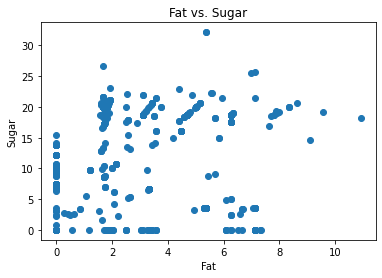

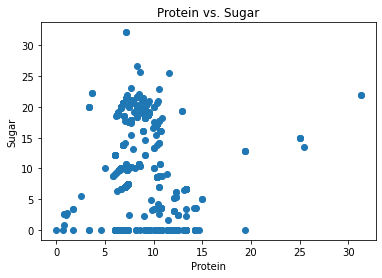

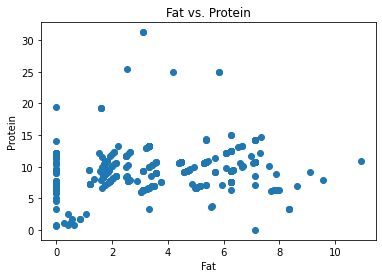

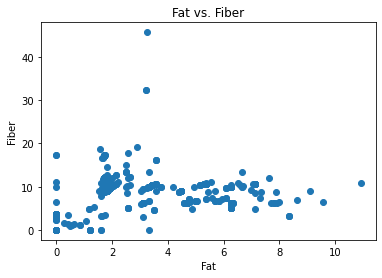

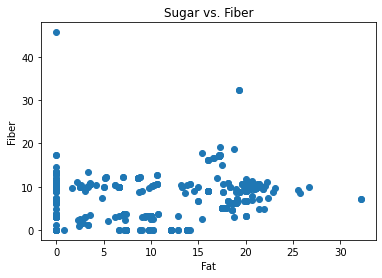

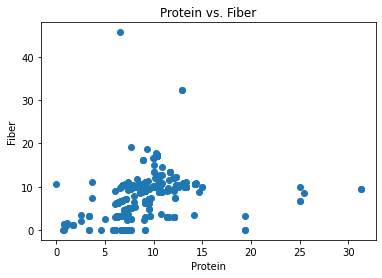

In [30]:
plt.scatter(Cereals['FAT'], Cereals['SUGAR'])
plt.title("Fat vs. Sugar")
plt.xlabel("Fat")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals['PROTEIN'], Cereals['SUGAR'])
plt.title("Protein vs. Sugar")
plt.xlabel("Protein")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals['FAT'], Cereals['PROTEIN'])
plt.title("Fat vs. Protein")
plt.xlabel("Fat")
plt.ylabel("Protein")
plt.show()

plt.scatter(Cereals['FAT'], Cereals['FIBER'])
plt.title("Fat vs. Fiber")
plt.xlabel("Fat")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals['SUGAR'], Cereals['FIBER'])
plt.title("Sugar vs. Fiber")
plt.xlabel("Fat")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals['PROTEIN'], Cereals['FIBER'])
plt.title("Protein vs. Fiber")
plt.xlabel("Protein")
plt.ylabel("Fiber")
plt.show()

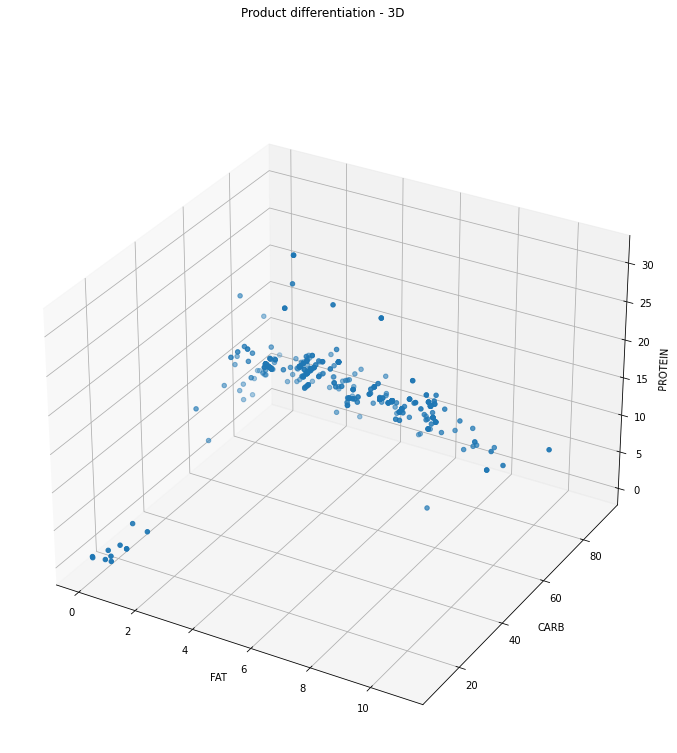

In [35]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals['FAT'], Cereals['CARB'],Cereals['PROTEIN'])

ax.set_xlabel('FAT')
ax.set_ylabel('CARB')
ax.set_zlabel('PROTEIN')

fig.suptitle('Product differentiation - 3D')
plt.show()

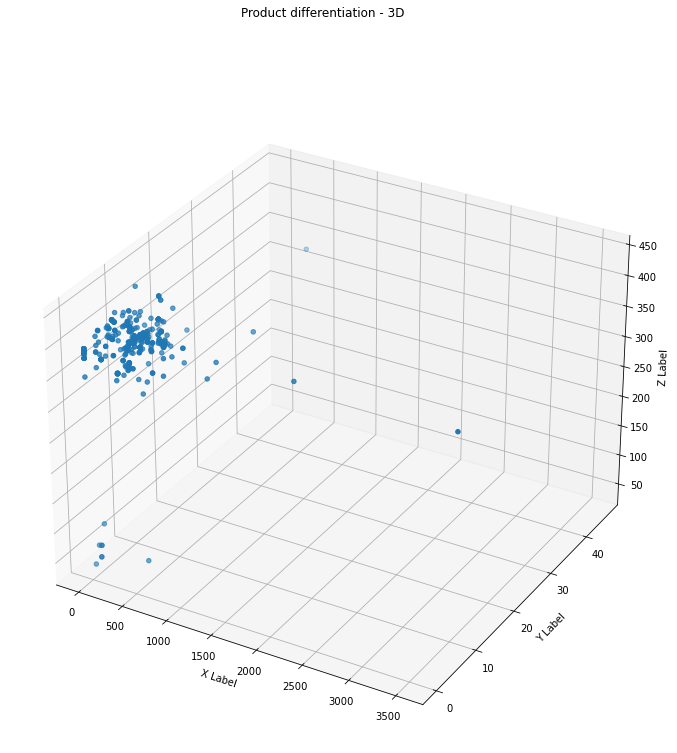

In [32]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals['CALCIUM'], Cereals['FIBER'],Cereals['CALORIES'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig.suptitle('Product differentiation - 3D')
plt.show()

### 2.2 K-Means clustering
Using the K-means clustering technique analyze the degree of product differentiation. Based on descriptive statistics, data availability, and scatter plots, choose pairs of features (i.e., nutrition facts) on which you believe the sellers differentiate themselves. Quantify your answer. You should try different K parameters. Report the goodness of fit (total sum of errors). *Instead of different pairs of features you can focus on the same pair and compare different locations or different supermarkets.*

## 3 Conclusions
Summarize your findings and draw conclusions from them. What can you recommend to cereal producers on the market? Do you find this market to be saturated? Here, I leave it to you to analyze your findings as you see fit. Given all the effort you have put, This section should be as very important.